# FedFromScratch
## A local implementation of the Federated Learning algorithm (FedAvg) in plain torch


## Introduction

Federated Learning is a distributed machine learning approach that allows training a global model across multiple devices or servers holding local data samples, without exchanging them. The idea is to train a global model by averaging the local models of each device. This way, the data remains on the device, and only the model is shared. This approach is particularly useful when the data is sensitive and cannot be shared, or when the data is too large to be centralized.

More formally, the Federated Learning algorithm can be described as follows:

1. Initialize the global model parameters $\theta$.
2. For each round $r$ in $1, \ldots, R$:
    1. For each `client` $k$ in $1, \ldots, K$:
        1. Send the global model parameters $\theta$ to device $k$.
        2. Train the local models $\theta_k$ using the local data $D_k$ (possibly non iid): $\theta_k \leftarrow \eta_k\nabla_\theta\mathcal{L}(\mathbf{y}, \mathbf{l})$.
        3. Send the local model parameters $\theta_k$ to the server.
    2. Update the global model parameters $\theta \leftarrow \theta = \frac{1}{K} \sum_{k=1}^K \theta_k$
3. Return the global model parameters $\theta$.

In this notebook, we will implement the Federated Learning algorithm in plain torch, using the MNIST dataset. We will use a simple CNN model, and we will train it emulating clients behavior by running each client on a separate process through Joblib. Implementation details and code are proided in the "models.py" file.

Note that we are making simplyfiying assumptions in this implementation, such as the fact that all clients are trained together and they have the same number of samples. In practice, the data is often non-iid, and the clients have different number of samples, or are not available together to train. For this project purposes, we will keep the implementation simple and focus on the core idea of Federated Learning.

## Basic setup and "monolithic" training of the model

In the following cell, we will define the basic setup for the training of the model. We will define the model, the loss function, the optimizer, and the data loaders. We will train the model on the whole dataset to have a baseline to compare the Federated Learning approach.

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


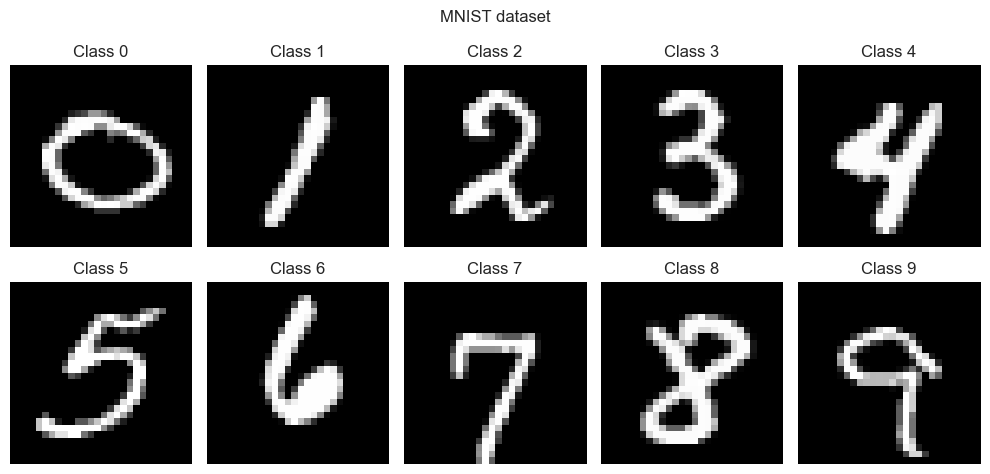

In [7]:
# set autoreload
%load_ext autoreload
%autoreload 2

from models import ConvNet, FederatedServer, ConvNetTrainer, init_clients
import matplotlib.pyplot as plt
import seaborn as sns
import pickle
import numpy as np
import torch
from utils import plot_mnist, get_mnist_dataloader

# firstly, we create the dataloader for the MNIST dataset
train, val, test = get_mnist_dataloader(64)
plot_mnist(train, 10, 5)

# set grid
sns.set_style("whitegrid")

In [ ]:
trainer = ConvNetTrainer(
    ConvNet(),
    train,  # training set
    val,  # using validation set
    device="mps",  # training using Apple's Metal Performance Shaders, you can also use 'cuda' or 'cpu'
    weight_decay=1e-5,
    lr=0.01,
)

# training the model on the whole training sety (50000 samples), for 10 epochs.
# Optimizer is Adam, with a learning rate of 0.001 and a weight decay of 0.0001
# since this is a very simple task, we can safely ignore a proper model selection procedure.
trainer.train(16)
loss, accuracy = trainer.test(test)

print(f"Test loss: {loss:.4f}, accuracy: {accuracy:.4f}")

### We now have a solid baseline model that we will use to compare the performance of the Federated Learning approach.
Without model selelction and further tuning, we reached a CE loss of $0.0456$ and an accuracy of $98.47%$ on the blind test set.

Let's now test the Federated Learning approach. We will first test it on 10 clients, although the number of clients can be easily increased by changing the `n_clients` parameter.

We will train the same model architecture on each client, and according to the algorithm, we will average the weights of the models at the end of each round.  

Each client will draw a subset of 512 data points from the training set, and we will train the model for 5 epochs on each client. We will run 64 rounds of training (64 global updates), with 10 jobs running in parallel (my machine has 10 cores...): in this case, we are assuming that the data is IID across the clients; we will further release this assumption. These parameers reflect those of the original FedAvg paper.

> Note: with this simple setup, we will not implement any advanced techniques to improve the performance of the model, such as learning rate scheduling, early stopping, or data augmentation. The goal is to provide a simple implementation of the Federated Learning algorithm in plain torch. 

> Note: in the spirit of FedAvg, the server is not aware of the data distribution on the clients.

In [3]:
model5e10c = ConvNet()
server5e10c = FederatedServer(model=model5e10c, test_loader=val)

# we first create 10 clients
clients = init_clients(
    num_clients=10,
    local_epochs=5,
    lr=1e-2,
    train_dataset=train,
    n_samples=512,
    device="mps",
    weight_decay=1e-6,
    sample_method="iid",
)

loss_5, acc_5 = server5e10c.start_train(clients, n_rounds=128, n_jobs=10)

# save history
# save history
with open("../histories/history_5e10c.pkl", "wb") as f:
    pickle.dump({"loss": loss_5, "accuracy": acc_5}, f)

> Client 0 created, lr: 0.01, epochs: 5, samples: 512, device: mps, weight_decay: 1e-06
> Client 1 created, lr: 0.01, epochs: 5, samples: 512, device: mps, weight_decay: 1e-06
> Client 2 created, lr: 0.01, epochs: 5, samples: 512, device: mps, weight_decay: 1e-06
> Client 3 created, lr: 0.01, epochs: 5, samples: 512, device: mps, weight_decay: 1e-06
> Client 4 created, lr: 0.01, epochs: 5, samples: 512, device: mps, weight_decay: 1e-06
> Client 5 created, lr: 0.01, epochs: 5, samples: 512, device: mps, weight_decay: 1e-06
> Client 6 created, lr: 0.01, epochs: 5, samples: 512, device: mps, weight_decay: 1e-06
> Client 7 created, lr: 0.01, epochs: 5, samples: 512, device: mps, weight_decay: 1e-06
> Client 8 created, lr: 0.01, epochs: 5, samples: 512, device: mps, weight_decay: 1e-06
> Client 9 created, lr: 0.01, epochs: 5, samples: 512, device: mps, weight_decay: 1e-06


100%|████████████████| 128/128 [06:05<00:00,  2.85s/it, Loss: 0.068, Acc: 97.92]


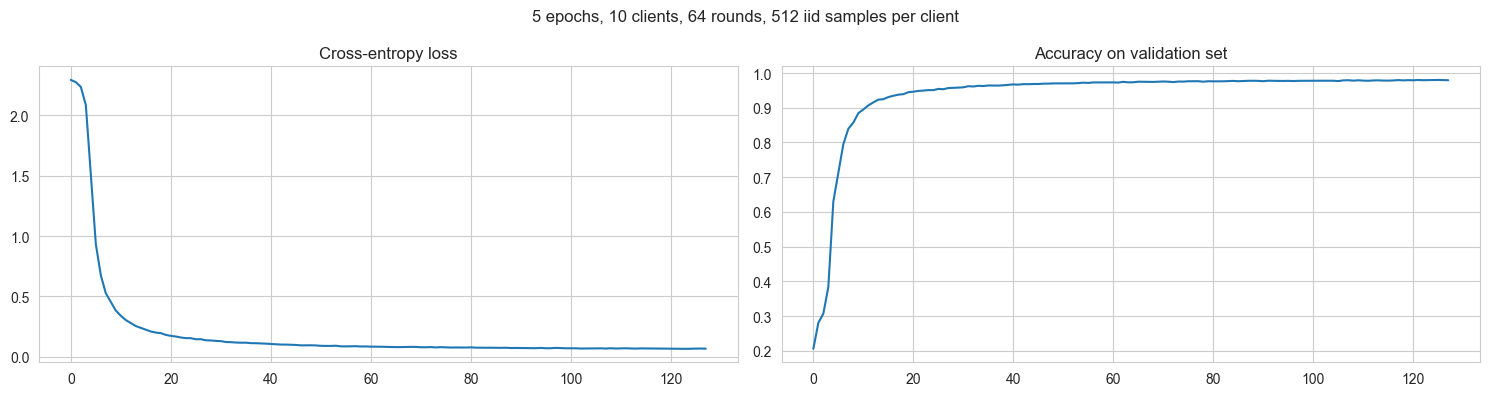

Test loss: 0.0561, accuracy: 0.9828


In [6]:
fig, axs = plt.subplots(1, 2, figsize=(15, 4))
axs[0].plot(loss_5)
axs[0].set_title("Cross-entropy loss")
axs[1].plot(acc_5)
axs[1].set_title("Accuracy on validation set")

# set suptitle
fig.suptitle("5 epochs, 10 clients, 64 rounds, 512 iid samples per client")
fig.tight_layout()
plt.show()

# test the model
server5e10c.test_loader = test
loss, accuracy = server5e10c.test()
print(f"Test loss: {loss:.4f}, accuracy: {accuracy:.4f}")

### It works! The model trained with Federated Learning reached a CE loss of $0.0561$ and an accuracy of $98.28\%$ on the blind test set.
(I think that there is still some margin for improvement, but the results are already quite good!)


## Testing fedavg on MNIST dataset with different numbers of epochs per client

In [ ]:
model5e = ConvNet()
server5e = FederatedServer(model=model5e, test_loader=val)

clients = init_clients(
    num_clients=5,
    local_epochs=5,
    lr=1e-2,
    train_dataset=train,
    n_samples=256,
    device="mps",
    weight_decay=1e-8,
    sample_method="iid",
)

loss_5e, acc_5e = server5e.start_train(clients, n_rounds=64, n_jobs=8)

# save history
with open("../histories/history_5e5c.pkl", "wb") as f:
    pickle.dump({"loss": loss_5e, "accuracy": acc_5e}, f)


model10e = ConvNet()
server10e = FederatedServer(model=model10e, test_loader=val)

clients = init_clients(
    num_clients=10,
    local_epochs=5,
    lr=1e-2,
    train_dataset=train,
    n_samples=256,
    device="mps",
    weight_decay=1e-8,
)

loss_10e, acc_10e = server10e.start_train(clients, n_rounds=64, n_jobs=8)

# save history
with open("../histories/history_5e10c.pkl", "wb") as f:
    pickle.dump({"loss": loss_10e, "accuracy": acc_10e}, f)

model20e = ConvNet()
server20e = FederatedServer(model=model20e, test_loader=val)
clients = init_clients(
    num_clients=20,
    local_epochs=5,
    lr=1e-2,
    train_dataset=train,
    n_samples=256,
    device="mps",
    weight_decay=1e-8,
)

loss_20e, acc_20e = server20e.start_train(clients, n_rounds=64, n_jobs=8)

# save history
with open("../histories/history_5e20c.pkl", "wb") as f:
    pickle.dump({"loss": loss_20e, "accuracy": acc_20e}, f)

In [14]:
# load histories and convert them to numpy arrays (i made the notebook in several days, so i saved the histories)
with open("../histories/history_5e5c.pkl", "rb") as f:
    history_5e5c = pickle.load(f)
    loss_5e5c = np.array(history_5e5c["loss"])
    acc_5e5c = np.array(history_5e5c["accuracy"])

with open("../histories/history_5e10c.pkl", "rb") as f:
    history_5e10c = pickle.load(f)
    loss_5e10c = np.array(history_5e10c["loss"])
    acc_5e10c = np.array(history_5e10c["accuracy"])

with open("../histories/history_5e20c.pkl", "rb") as f:
    history_5e20c = pickle.load(f)
    loss_5e20c = np.array(history_5e20c["loss"])
    acc_5e20c = np.array(history_5e20c["accuracy"])

In [8]:
# test all models
server5e.test_loader = test
server10e.test_loader = test
server20e.test_loader = test

loss_5e, acc_5e = server5e.test()
loss_10e, acc_10e = server10e.test()
loss_20e, acc_20e = server20e.test()

print(f"5 clients, 5 epochs, 256 samples iid: {acc_5e:.2%}")
print(f"10 clients, 5 epochs, 256 samples iid: {acc_10e:.2%}")
print(f"20 clients, 5 epochs, 256 samples iid: {acc_20e:.2%}")

5 clients, 5 epochs, 256 samples iid: 96.20%
10 clients, 5 epochs, 256 samples iid: 96.04%
20 clients, 5 epochs, 256 samples iid: 96.31%


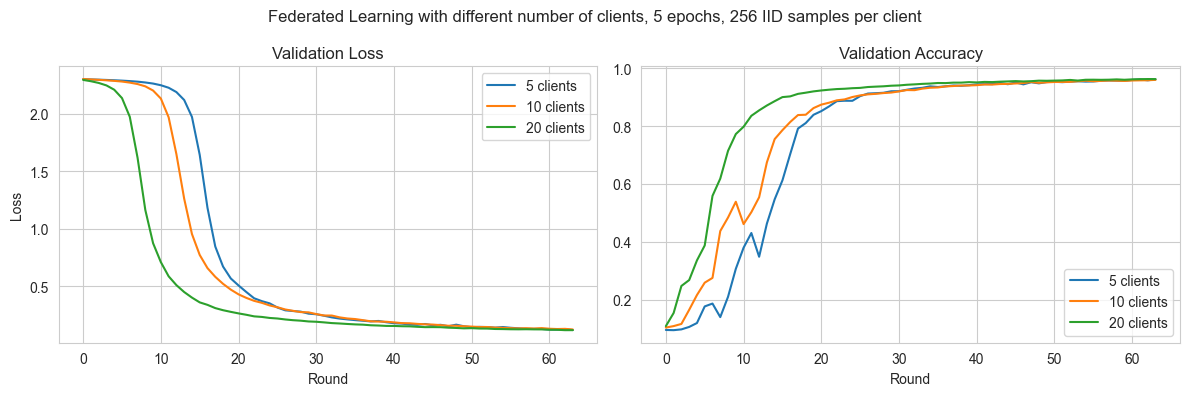

In [22]:
import matplotlib.pyplot as plt
import seaborn as sns

# set grid
sns.set_style("whitegrid")

# plot the losses and accuracies
fig, axs = plt.subplots(1, 2, figsize=(12, 4))

axs[0].plot(loss_5e5c, label="5 clients")
axs[0].plot(loss_5e10c, label="10 clients")
axs[0].plot(loss_5e20c, label="20 clients")
axs[0].set_title("Validation Loss")
axs[0].set_xlabel("Round")
axs[0].set_ylabel("Loss")
axs[0].legend()

axs[1].plot(acc_5e5c, label="5 clients")
axs[1].plot(acc_5e10c, label="10 clients")
axs[1].plot(acc_5e20c, label="20 clients")
axs[1].set_title("Validation Accuracy")
axs[1].set_xlabel("Round")
axs[1].legend()

# set super title
plt.suptitle(
    "Federated Learning with different number of clients, 5 epochs, 256 IID samples per client"
)
# add some space between the plots
plt.tight_layout()

plt.show()

### Brief comment on the results of this experiment

This results show how all configurations were able to reach satisfying performances and, as I was expecting, the higher the number of the clients, the higher the faster the convergence. However, all models will eventually converge to a stable point. The results are quite good and impressing, considering the low number of data points sampled by each client and the simplicity of the tested CNN used.
We will now proceed to assess performance of federated learning on a more "realistic" scenario, with many clients and small data samples for client.

### Now, let's test federated learning with many clients, each one sampling very few data points from the training set. Again, the distribution is iid across the clients.
This expetiment aims to simulate a more realistic scenario where the data samples are few and distributed across many clients. We will use 128 clients, each one drawing 32 data points from the training set. We will train the model for 5 epochs on each client, and we will run 64 rounds of training with 16 jobs running in parallel.

In [ ]:
model5e128c = ConvNet()
server = FederatedServer(model=model5e128c, test_loader=val)

clients = init_clients(
    num_clients=128,
    local_epochs=5,
    lr=1e-2,
    train_dataset=train,
    n_samples=32,
    device="mps",
    weight_decay=1e-10,
    sample_method="iid",
)

loss5e128c, acc5e128c = server.start_train(clients, n_rounds=128, n_jobs=10)

# save history
with open("history_5e128c.pkl", "wb") as f:
    pickle.dump({"loss": loss5e128c, "accuracy": acc5e128c}, f)

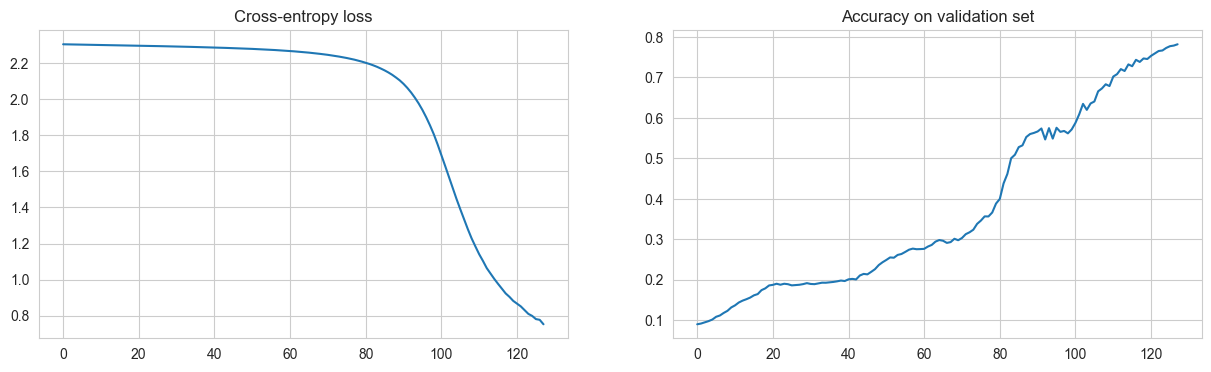

In [29]:
with open("../histories/history_5e128c.pkl", "rb") as f:
    history = pickle.load(f)

loss5e128c = history["loss"]
acc_5e128c = history["accuracy"]

fig, axs = plt.subplots(1, 2, figsize=(15, 4))
axs[0].plot(loss5e128c)
axs[0].set_title("Cross-entropy loss")

axs[1].plot(acc_5e128c)
axs[1].set_title("Accuracy on validation set")
plt.show()

### Convergence is really slow.
However, after many rounds, model suddently starts to improve and generalize. This suggests exactly what we would expect in a federated learning scenario: the model is able to learn from the local data of each client, and it is able to generalize to the global data distribution. This is a very interesting result, and it shows the potential of Federated Learning in real-world scenarios. Moreover, in a more realistic setting, where clients only have to fine-tune the model (e.g. few-shot learning), it is my opinion that the convergence would be much faster.

We will now proceed to test the federated learning performance on a more realistic scenario, where the data is non-iid across the clients.

## The pathological case: non-iid data distribution across the clients

In a federated learning application (e.g. keyboard text prediction) we must release the assumption that the data is iid across the clients: we can have sampling bias and different data distributions across the clients, e.g. different languages, different writing styles, etc. We will try to check how the model performs in this case.

Experimental setup:
In order to simulate what the authors of the original FedAvg refer to "pathological non iid case" we will split the MNIST dataset in 10 shards, each one containing the images of two digits. This is a very simple (though extreme) way to create a non-iid data distribution across the clients. We will then train the model on 10 clients, each one holding a different sample of its assigned digits.

Full code of this split is straightforward and it is reported in the following snippet for completeness:

```python

def _sample_data_noniid(self):
    # select a a key from the mnist dataset randomly
    subset_a = [s for s in self.train_loader.dataset if s[1] == self.k % 10]
    subset_b = [s for s in self.train_loader.dataset if s[1] == (self.k + 1) % 10]
    # sample n_samples from the subset
    subset_a = Subset(subset_a, list(RandomSampler(subset_a, num_samples=self.n_samples//2)))
    subset_b = Subset(subset_b, list(RandomSampler(subset_b, num_samples=self.n_samples//2)))

    subset = torch.utils.data.ConcatDataset([subset_a, subset_b])
```

I expect this setup to be very challenging for the model, since we are again starting from a random weights configuration and averaging models trained on completely different data.

In [ ]:
model_niid = ConvNet()
server_niid = FederatedServer(model=model_niid, test_loader=val)

clients = init_clients(
    num_clients=16,
    local_epochs=5,
    lr=1e-2,
    train_dataset=train,
    n_samples=256,
    device="mps",
    weight_decay=1e-10,
    sample_method="niid",
)

loss_niid, acc_niid = server_niid.start_train(clients, n_rounds=64, n_jobs=8)

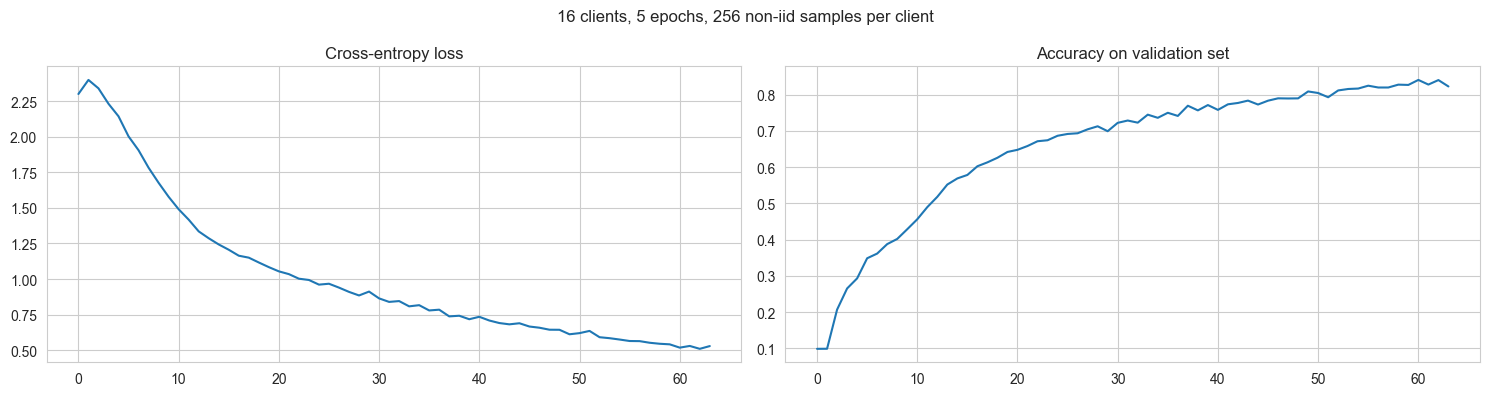

In [9]:
# save history
with open("../histories/history_niid.pkl", "wb") as f:
    pickle.dump({"loss": loss_niid, "accuracy": acc_niid}, f)

# plot history with seaborn
fig, axs = plt.subplots(1, 2, figsize=(15, 4))
axs[0].plot(loss_niid)
axs[0].set_title("Cross-entropy loss")
axs[1].plot(acc_niid)
axs[1].set_title("Accuracy on validation set")

# set suptitle
fig.suptitle("16 clients, 5 epochs, 256 non-iid samples per client")
fig.tight_layout()
plt.show()

## Results of the non-iid data distribution experiment

This convergence, with this particular configuration, is painfully slow: in fact, I was expecting this behaviour given the fact that each client is trained on a completely different data distribution. Each client is forced by its local SGD optimizer towards a distribution, and averaging weights will potentially distrupt local's optimization steps.

Nonetheles, the global model is able to learn from the local data of each client and to generalize to the global data distribution. Looking at the learning curves, I was expecting a slow convergence in the first epochs, and a sudden drop in the cross-entropy loss at a given epoch, when the global model, which started to generalize across all the dataset, was sent again to the clients. However, this is not what happened, and the convergence rate kept being the same across all the 64 global updates.


This is a very interesting result, and it shows the potential of Federated Learning in real-world scenarios. Again in a more realistic setting, where clients only have to fine-tune the model (e.g. few-shot learning), this would be much faster. I also thik that having an huge number of clients and rounds to train the global model will help the algorithm to converge faster. Unfortunately, I was not able to test this hypothesis due to the computational resources required.

## Another test: try fashion-mnist dataset

_"If it doesn't work on MNIST, it won't work at all", they said. "Well, if it does work on MNIST, it may still fail on others."_
In this perspective, let's try it on the fashion-mnist dataset, which is a bit more challenging than the original MNIST dataset.


### Again, let's first establish a baseline on the fashion-mnist dataset, with a simple cnn.

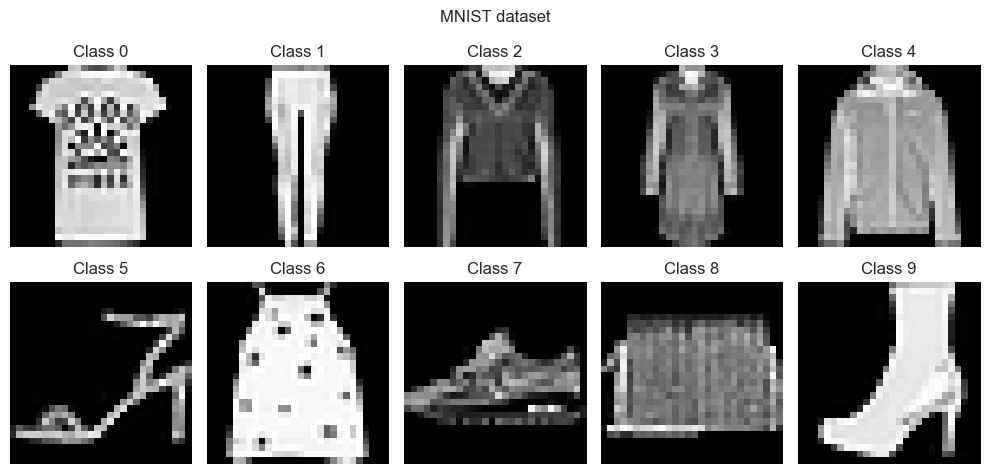

In [15]:
# import the fashion mnist dataset
from models import ConvNet, FederatedServer, ConvNetTrainer, init_clients
from utils import plot_mnist, get_fashion_mnist_dataloader
from matplotlib import pyplot as plt
import seaborn as sns

train, val, test = get_fashion_mnist_dataloader(64)

plot_mnist(train, 10, 5)

In [16]:
# train the model on the whole training set
trainer = ConvNetTrainer(
    ConvNet(), train, val, device="mps", weight_decay=1e-5, lr=0.01, optimizer="Adam"
)

trainer.train(24)
loss, accuracy = trainer.test(test)

print(f"Test loss: {loss:.4f}, accuracy: {accuracy:.4f}")

Using Adam
Model created and moved to mps
Total number of trainable parameters: 25034


100%|████████████████████████████████████████████████████████| 24/24 [03:43<00:00,  9.29s/it, Loss: 0.321, VL: 0.327, VA: 88.10]


Test loss: 0.3691, accuracy: 0.8717


Our baseline is a simple CNN that reached a CE loss of $0.327$ and an accuracy of $88.10\%$ on the blind test set. These results are coherent with the benchmarks for my simple CNN model on the fashion-mnist dataset.


### FashionFed

In [18]:
model5e10c = ConvNet()
server5e10c = FederatedServer(model=model5e10c, test_loader=val)

clients = init_clients(
    num_clients=20,  # 20 clients
    local_epochs=2,  # trying with 2 local epochs
    lr=1e-2,
    train_dataset=train,
    n_samples=512,
    device="mps",
    weight_decay=1e-6,
    sample_method="iid",
)

loss_5, acc_5 = server5e10c.start_train(clients, n_rounds=128, n_jobs=10)

# save history
with open("../histories/history_5e10c_fashion.pkl", "wb") as f:
    pickle.dump({"loss": loss_5, "accuracy": acc_5}, f)

# save global model
torch.save(server5e10c.global_model.state_dict(), "../models/model5e10c_fashion.pth")

> Client 0 created, lr: 0.01, epochs: 2, samples: 512, device: mps, weight_decay: 1e-06
> Client 1 created, lr: 0.01, epochs: 2, samples: 512, device: mps, weight_decay: 1e-06
> Client 2 created, lr: 0.01, epochs: 2, samples: 512, device: mps, weight_decay: 1e-06
> Client 3 created, lr: 0.01, epochs: 2, samples: 512, device: mps, weight_decay: 1e-06
> Client 4 created, lr: 0.01, epochs: 2, samples: 512, device: mps, weight_decay: 1e-06
> Client 5 created, lr: 0.01, epochs: 2, samples: 512, device: mps, weight_decay: 1e-06
> Client 6 created, lr: 0.01, epochs: 2, samples: 512, device: mps, weight_decay: 1e-06
> Client 7 created, lr: 0.01, epochs: 2, samples: 512, device: mps, weight_decay: 1e-06
> Client 8 created, lr: 0.01, epochs: 2, samples: 512, device: mps, weight_decay: 1e-06
> Client 9 created, lr: 0.01, epochs: 2, samples: 512, device: mps, weight_decay: 1e-06
> Client 10 created, lr: 0.01, epochs: 2, samples: 512, device: mps, weight_decay: 1e-06
> Client 11 created, lr: 0.01, 

100%|████████████████| 128/128 [06:50<00:00,  3.21s/it, Loss: 0.458, Acc: 83.65]


In [19]:
# test the model on the test set
with open("../histories/history_5e10c_fashion.pkl", "rb") as f:
    history = pickle.load(f)
    loss_5e10c = np.array(history["loss"])
    acc_5e10c = np.array(history["accuracy"])

server5e10c.test_loader = test
loss, accuracy = server5e10c.test()

print(f"Test loss: {loss:.4f}, accuracy: {accuracy:.4f}")

Test loss: 0.4856, accuracy: 0.8261


Text(0.5, 0.98, '5 epochs, 10 clients, 64 rounds, 512 iid samples per client')

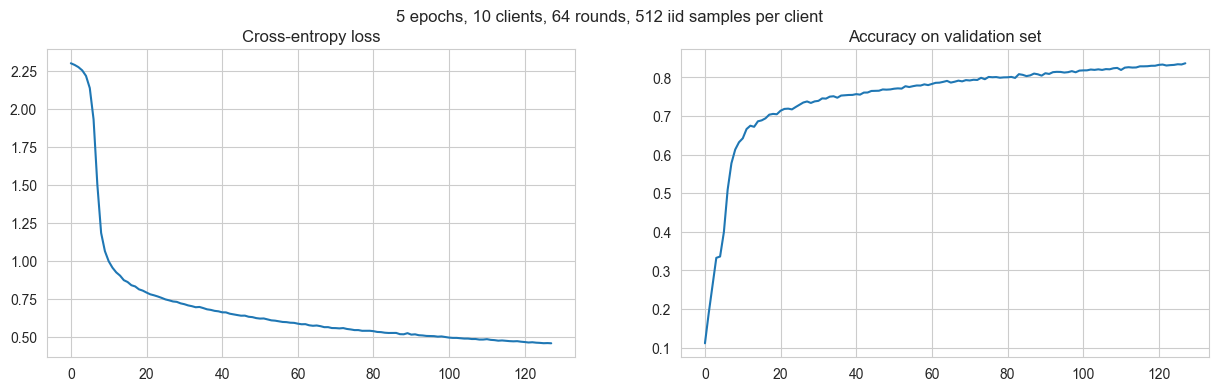

In [20]:
# plot history with seaborn
fig, axs = plt.subplots(1, 2, figsize=(15, 4))
axs[0].plot(loss_5e10c)
axs[0].set_title("Cross-entropy loss")
axs[1].plot(acc_5e10c)
axs[1].set_title("Accuracy on validation set")

# set suptitle
fig.suptitle("5 epochs, 10 clients, 64 rounds, 512 iid samples per client")

### Again, good results.
Model is able to learn quickly also from more complex datasets, achieving a total test accuracy of $82.31\%$ (increasing) and a CE loss of $0.4856$, reaching a good performance in a reasonable amount of time. Training for more epochs would probably lead to better results, but the goal of this experiment was to test the Federated Learning algorithm, and we have limited computational resources.

## Federated Fine-Tuning of EfficientNet on CIFAR10

As our final task, we will test the Federated Learning algorithm on a more complex dataset, CIFAR10. We will use a pre-trained EfficientNet B0 model, and we will fine-tune it on the CIFAR10 dataset using the Federated Learning algorithm. Standard Finetuning with AdamW lead to 80% accuracy on the test set. Results of this finetuning can be found in "ened.ipynb" notebook.

In [1]:
from utils import get_cifar10_dataloader, plot_mnist
from models import FederatedServer, init_clients

# import efficientnet from torchvision models

import torch
import torch.nn as nn
from torchvision.models import efficientnet_b0, EfficientNet_B0_Weights

train, val, test = get_cifar10_dataloader(64)
# resnet = resnet18(weights=ResNet18_Weights.IMAGENET1K_V1)
effnet = efficientnet_b0(weights=EfficientNet_B0_Weights.IMAGENET1K_V1)
for param in effnet.parameters():
    param.requires_grad = False
effnet.classifier[1] = nn.Linear(effnet.classifier[1].in_features, 102)

Files already downloaded and verified


In [2]:
# plot_mnist(train, 10, 5)

In [2]:
# initialize clients
clients = init_clients(
    num_clients=32,
    local_epochs=2,
    lr=1e-3,
    train_dataset=train,
    n_samples=512,
    device="mps",
    weight_decay=1e-6,
    sample_method="iid",
    model=effnet,
)

# create server
server = FederatedServer(model=effnet, test_loader=val)
loss, acc = server.start_train(clients, n_rounds=128, n_jobs=2)

> Client 0 created, lr: 0.001, epochs: 2, samples: 512, device: mps, weight_decay: 1e-06
> Client 1 created, lr: 0.001, epochs: 2, samples: 512, device: mps, weight_decay: 1e-06
> Client 2 created, lr: 0.001, epochs: 2, samples: 512, device: mps, weight_decay: 1e-06
> Client 3 created, lr: 0.001, epochs: 2, samples: 512, device: mps, weight_decay: 1e-06
> Client 4 created, lr: 0.001, epochs: 2, samples: 512, device: mps, weight_decay: 1e-06
> Client 5 created, lr: 0.001, epochs: 2, samples: 512, device: mps, weight_decay: 1e-06
> Client 6 created, lr: 0.001, epochs: 2, samples: 512, device: mps, weight_decay: 1e-06
> Client 7 created, lr: 0.001, epochs: 2, samples: 512, device: mps, weight_decay: 1e-06
> Client 8 created, lr: 0.001, epochs: 2, samples: 512, device: mps, weight_decay: 1e-06
> Client 9 created, lr: 0.001, epochs: 2, samples: 512, device: mps, weight_decay: 1e-06
> Client 10 created, lr: 0.001, epochs: 2, samples: 512, device: mps, weight_decay: 1e-06
> Client 11 created,

  2%|▎                  | 2/128 [00:45<47:07, 22.44s/it, Loss: 4.591, Acc: 2.12]/Users/vornao/Desktop/unipi/CL/project/.venv/lib/python3.12/site-packages/joblib/externals/loky/process_executor.py:752: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(
 40%|██████▊          | 51/128 [17:49<26:48, 20.89s/it, Loss: 2.849, Acc: 29.46]

In [ ]:
# test the model on the test set
loss, accuracy = trainer.test(test)

print(f"Test loss: {loss:.4f}, accuracy: {accuracy:.4f}")

Test loss: 1.7798, accuracy: 0.7002


In [ ]:
# save finetuned model
torch.save(resnet.state_dict(), "../models/resnet18_cifar10.pth")